In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

class OrderBook:
    def __init__(self, initial_price=100.0, volatility_factor=0.5):
        self.bids = []  # List of [price, quantity]
        self.asks = []  # List of [price, quantity]
        self.mid_price = initial_price
        self.volatility_factor = volatility_factor 
        self.history = [] 

    def add_random_orders(self, num_orders=10):
        """Simulate incoming limit orders around the mid_price"""
        for _ in range(num_orders):
            side = np.random.choice(['bid', 'ask'])
            
            offset = np.abs(np.random.normal(0, self.volatility_factor))
            qty = np.random.randint(1, 100)

            if side == 'bid':
                price = np.round(self.mid_price - offset, 2)
                self.bids.append([price, qty])
            else:
                price = np.round(self.mid_price + offset, 2)
                self.asks.append([price, qty])
        
        # Sort books: Bids descending, Asks ascending
        self.bids = sorted(self.bids, key=lambda x: x[0], reverse=True)
        self.asks = sorted(self.asks, key=lambda x: x[0])
        
        while self.bids and self.asks and self.bids[0][0] >= self.asks[0][0]:
            best_bid = self.bids[0] 
            best_ask = self.asks[0] 
            
            trade_qty = min(best_bid[1], best_ask[1])
            
            best_bid[1] -= trade_qty
            best_ask[1] -= trade_qty
            
            if best_bid[1] == 0:
                self.bids.pop(0)
                
            if best_ask[1] == 0:
                self.asks.pop(0)
                
        self._record_metrics()

    def _record_metrics(self):
        """Record the current spread for analysis"""
        if self.bids and self.asks:
            best_bid = self.bids[0][0]
            best_ask = self.asks[0][0]
            spread = best_ask - best_bid
            self.mid_price = (best_bid + best_ask) / 2
            self.history.append({'time': len(self.history), 'spread': spread, 'mid': self.mid_price})

    def get_depth_frame(self):
        """Return dataframes for plotting"""
        df_bids = pd.DataFrame(self.bids, columns=['price', 'quantity'])
        df_asks = pd.DataFrame(self.asks, columns=['price', 'quantity'])
        
        if not df_bids.empty:
            df_bids = df_bids.groupby('price').sum().reset_index().sort_values('price', ascending=False)
        if not df_asks.empty:
            df_asks = df_asks.groupby('price').sum().reset_index().sort_values('price', ascending=True)
        
        return df_bids, df_asks

1000 Traders

In [2]:
equity_market = OrderBook(initial_price=150.0, volatility_factor=0.2) # Tighter
crypto_market = OrderBook(initial_price=150.0, volatility_factor=2.0) # Wider/Volatile

# Simulation Loop: 1000 Traders arriving
for i in range(1000):
    num_arrivals = np.random.poisson(lam=5) 
    equity_market.add_random_orders(num_arrivals)
    crypto_market.add_random_orders(num_arrivals)

print("Simulation Complete.")

Simulation Complete.


Visualisation

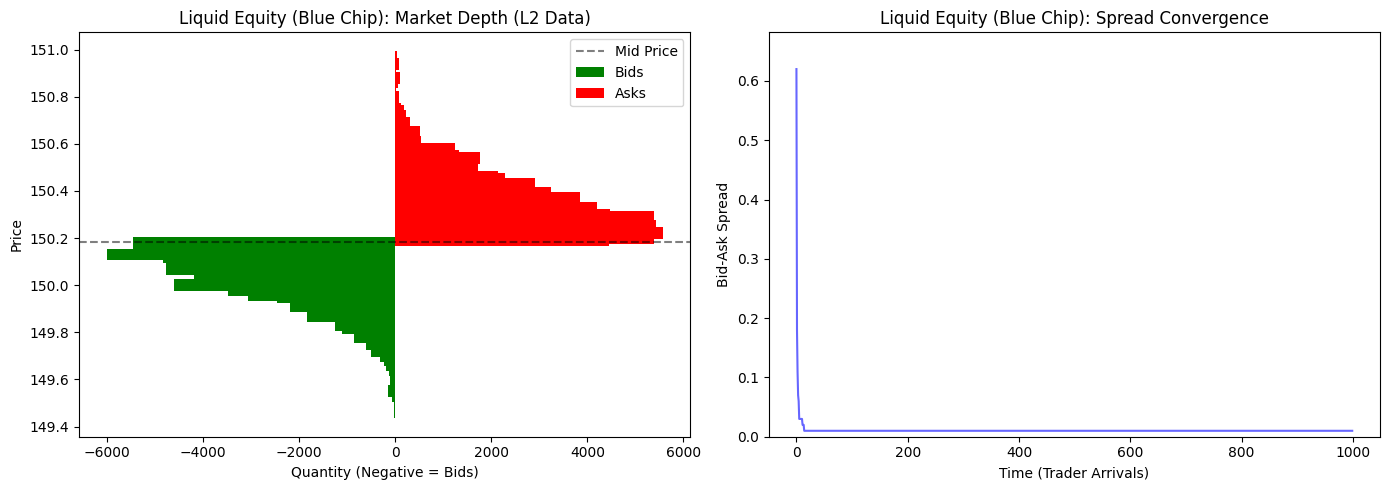

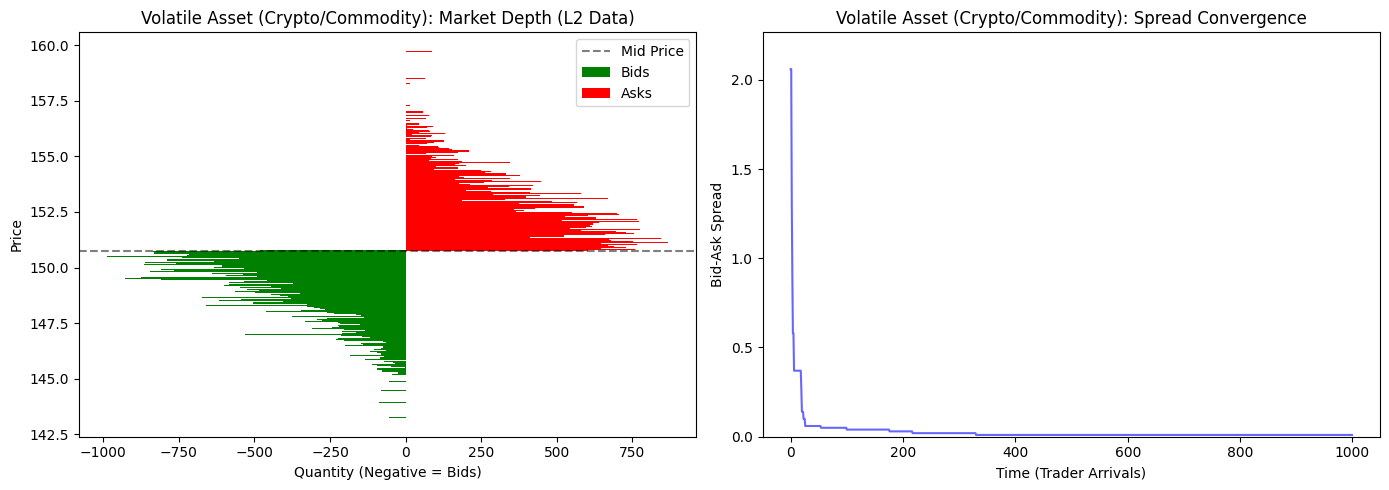

In [3]:
def plot_market_depth(market, title):
    bids, asks = market.get_depth_frame()
    
    view_range = 10 # View $10 range around mid
    mid = market.mid_price
    
    bids = bids[bids['price'] > (mid - view_range)]
    asks = asks[asks['price'] < (mid + view_range)]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # --- Plot 1: The Depth Chart (Order Book Shape) ---
    # Bids on Left (Green), Asks on Right (Red)
    ax1.barh(bids['price'], -bids['quantity'], color='green', height=0.05, label='Bids')
    ax1.barh(asks['price'], asks['quantity'], color='red', height=0.05, label='Asks')
    
    ax1.set_xlabel('Quantity (Negative = Bids)')
    ax1.set_ylabel('Price')
    ax1.set_title(f'{title}: Market Depth (L2 Data)')
    ax1.axhline(market.mid_price, color='black', linestyle='--', alpha=0.5, label='Mid Price')
    ax1.legend()
    
    # --- Plot 2: Spread Convergence (Time Series) ---
    history_df = pd.DataFrame(market.history)
    ax2.plot(history_df['time'], history_df['spread'], color='blue', alpha=0.6)
    ax2.set_xlabel('Time (Trader Arrivals)')
    ax2.set_ylabel('Bid-Ask Spread')
    ax2.set_title(f'{title}: Spread Convergence')
    ax2.set_ylim(0, max(history_df['spread'])*1.1)
    
    plt.tight_layout()
    plt.show()

# Run the plots
plot_market_depth(equity_market, "Liquid Equity (Blue Chip)")
plot_market_depth(crypto_market, "Volatile Asset (Crypto/Commodity)")